In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

module_path = (Path().resolve().parent/ "Modules")
sys.path.append(str(module_path))

import my_modules, model_tuner, features

pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = pd.read_csv("../Data/train_data_tmp.csv", encoding="shift-jis")
odds_df = pd.read_csv("../Data/Time_Series_Odds_win_odds.csv", encoding="shift-jis")

In [15]:
df2 = my_modules.preprocessing(df)

In [16]:
df3 = my_modules.common_process(df2)

<string>:16: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [17]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252411 entries, 252634 to 0
Data columns (total 75 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   race_id              252411 non-null  int64         
 1   year                 252411 non-null  int64         
 2   month                252411 non-null  int64         
 3   day                  252411 non-null  int64         
 4   times                252411 non-null  int64         
 5   place                252411 non-null  object        
 6   daily                252411 non-null  object        
 7   race_num             252411 non-null  int64         
 8   horse                252411 non-null  object        
 9   jockey_id            252411 non-null  object        
 10  trainer_id           252411 non-null  int64         
 11  horse_N              252411 non-null  object        
 12  waku_num             252411 non-null  int64         
 13  horse_num          

In [ ]:
df3.head()

,age,age_type
252634,3,3
252635,3,3
252633,3,3
252632,3,3
252631,3,3
...,...,...
7,3,3
9,4,over4
10,5,over4
5,4,over4


In [ ]:
feature_col = ["waku_num", "horse_num", "sex", "age", "basis_weight", "weight", "inc_dec", "age_type"]
df4, feature_col2 = features.feature_engineering(df3, feature_col)

calculating trueskill of horse is processing
calculating trueskill of jockey is processing


C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped = df.groupby(["horse", *cols], observed=True)["target3"]
C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  grouped = df.groupby(["horse", *cols], observed=True)["target3"]
C:\Users\ken05\Documents\others\HORSE_RACING\Modules\features.py:284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

['waku_num', 'horse_num', 'sex', 'age', 'basis_weight', 'weight', 'inc_dec', 'weight_last_1', 'weight_last_2', 'weight_last_3', 'weight_mean_last_1_to_3', 'weight_mean_all', 'inc_dec_last_1', 'inc_dec_last_2', 'inc_dec_last_3', 'inc_dec_mean_last_1_to_3', 'inc_dec_mean_all', 'last_3F_time_last_1', 'last_3F_time_last_2', 'last_3F_time_last_3', 'last_3F_time_mean_last_1_to_3', 'last_3F_time_mean_all', 'Ave_3F_last_1', 'Ave_3F_last_2', 'Ave_3F_last_3', 'Ave_3F_mean_last_1_to_3', 'Ave_3F_mean_all', 'all_win_rate_horse', 'all_win_rate3_horse', 'horse_win_rate_dist', 'horse_win_rate3_dist', 'horse_win_rate_track_code', 'horse_win_rate3_track_code', 'horse_win_rate_field_type', 'horse_win_rate3_field_type', 'horse_win_rate_turn_type', 'horse_win_rate3_turn_type', 'horse_win_rate_weather', 'horse_win_rate3_weather', 'horse_win_rate_state', 'horse_win_rate3_state', 'horse_win_rate_place', 'horse_win_rate3_place', 'horse_win_rate_corner_num', 'horse_win_rate3_corner_num', 'horse_win_rate_class_c

,race_id,year,month,day,times,place,daily,race_num,horse,jockey_id,trainer_id,horse_N,waku_num,horse_num,class_code,track_code,corner_num,dist,state,weather,age_code,sex,age,basis_weight,blinker,weight,inc_dec,weight_code,win_odds,win_odds_1,win_odds_1_pop,win_odds_2,win_odds_2_pop,win_mul_odds_Hi,win_mul_odds_Lo,win_mul_odds_1_Hi,win_mul_odds_1_Lo,win_mul_odds_1_pop,win_mul_odds_2_Hi,win_mul_odds_2_Lo,win_mul_odds_2_pop,rank,time_diff,time,corner1_rank,corner2_rank,corner3_rank,corner4_rank,last_3F_time,last_3F_rank,Ave_3F,PCI,PCI3,RPCI,last_3F_time_diff,leg,pop,prize,error_code,father,mother,broodmare_sire,broodmare_sire_type,horse_color,id,id_for_fold,field_type,flat_or_jump,turn_type,race_type,waku,datetime,target,target3,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,horse_win_rate_dist,horse_win_rate3_dist,horse_win_rate_track_code,horse_win_rate3_track_code,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate_turn_type,horse_win_rate3_turn_type,horse_win_rate_weather,horse_win_rate3_weather,horse_win_rate_state,horse_win_rate3_state,horse_win_rate_place,horse_win_rate3_place,horse_win_rate_corner_num,horse_win_rate3_corner_num,horse_win_rate_class_code,horse_win_rate3_class_code,horse_win_rate_basis_weight,horse_win_rate3_basis_weight,horse_win_rate_age_code,horse_win_rate3_age_code,horse_win_rate_weight_code,horse_win_rate3_weight_code,horse_win_rate_jockey_id,horse_win_rate3_jockey_id,horse_win_rate_jockey_id_field_type,horse_win_rate3_jockey_id_field_type,horse_win_rate_weather_state,horse_win_rate3_weather_state,horse_win_rate_dist_corner_num,horse_win_rate3_dist_corner_num,horse_win_rate_dist_track_code,horse_win_rate3_dist_track_code,horse_win_rate_dist_class_code,horse_win_rate3_dist_class_code,horse_win_rate_place_field_type_dist,horse_win_rate3_place_field_type_dist,all_win_rate_horse,all_win_rate3_horse,all_win_rate_dist_waku,all_win_rate3_dist_waku,all_win_rate_field_type_waku,all_win_rate3_field_type_waku,all_win_rate_place_waku,all_win_rate3_place_waku,all_win_rate_field_type_dist_waku,all_win_rate3_field_type_dist_waku,all_win_rate_dist_place_waku,all_win_rate3_dist_place_waku,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate_race_type_waku,all_win_rate3_race_type_waku,all_win_rate_corner_num_waku,all_win_rate3_corner_num_waku,all_win_rate_corner_num_dist_waku,all_win_rate3_corner_num_dist_waku,all_win_rate_corner_num_place_waku,all_win_rate3_corner_num_place_waku,all_win_rate_corner_num_field_type_waku,all_win_rate3_corner_num_field_type_waku,all_win_rate_jockey_id,all_win_rate3_jockey_id,all_win_rate_jockey_id_place,all_win_rate3_jockey_id_place,all_win_rate_jockey_id_place_dist,all_win_rate3_jockey_id_place_dist,all_win_rate_jockey_id_field_type,all_win_rate3_jockey_id_field_type,all_win_rate_jockey_id_field_type_dist,all_win_rate3_jockey_id_field_type_dist,all_win_rate_jockey_id_field_type_place,all_win_rate3_jockey_id_field_type_place,all_win_rate_jockey_id_dist,all_win_rate3_jockey_id_dist,all_win_rate_jockey_id_race_type,all_win_rate3_jockey_id_race_type,all_win_rate_jockey_id_race_type_waku,all_win_rate3_jockey_id_race_type_waku,all_win_rate_jockey_id_class_code,all_win_rate3_jockey_id_class_code,all_win_rate_jockey_id_class_code_place,all_win_rate3_jockey_id_class_code_place,all_win_rate_jockey_id_class_code_dist,all_win_rate3_jockey_id_class_code_dist,all_win_rate_jockey_id_class_code_field_type,all_win_rate3_jockey_id_class_code_field_type,all_win_rate_jockey_id_class_code_race_type,all_win_rate3_jockey_id_class_code_race_type,all_win_rate_jockey_id_class_code_race_type_waku,all_win_rate3_jockey_id_class_code_race_type_waku,all_win_rate_

In [8]:
df4[feature_col2]

,waku_num,horse_num,sex,age,basis_weight,weight,inc_dec,weight_last_1,weight_last_2,weight_last_3,weight_mean_last_1_to_3,weight_mean_all,inc_dec_last_1,inc_dec_last_2,inc_dec_last_3,inc_dec_mean_last_1_to_3,inc_dec_mean_all,last_3F_time_last_1,last_3F_time_last_2,last_3F_time_last_3,last_3F_time_mean_last_1_to_3,last_3F_time_mean_all,Ave_3F_last_1,Ave_3F_last_2,Ave_3F_last_3,Ave_3F_mean_last_1_to_3,Ave_3F_mean_all,all_win_rate_horse,all_win_rate3_horse,horse_win_rate_dist,horse_win_rate3_dist,horse_win_rate_track_code,horse_win_rate3_track_code,horse_win_rate_field_type,horse_win_rate3_field_type,horse_win_rate_turn_type,horse_win_rate3_turn_type,horse_win_rate_weather,horse_win_rate3_weather,horse_win_rate_state,horse_win_rate3_state,horse_win_rate_place,horse_win_rate3_place,horse_win_rate_corner_num,horse_win_rate3_corner_num,horse_win_rate_class_code,horse_win_rate3_class_code,horse_win_rate_basis_weight,horse_win_rate3_basis_weight,horse_win_rate_age_code,horse_win_rate3_age_code,horse_win_rate_weight_code,horse_win_rate3_weight_code,horse_win_rate_jockey_id,horse_win_rate3_jockey_id,horse_win_rate_jockey_id_field_type,horse_win_rate3_jockey_id_field_type,horse_win_rate_weather_state,horse_win_rate3_weather_state,horse_win_rate_dist_corner_num,horse_win_rate3_dist_corner_num,horse_win_rate_dist_track_code,horse_win_rate3_dist_track_code,horse_win_rate_dist_class_code,horse_win_rate3_dist_class_code,horse_win_rate_place_field_type_dist,horse_win_rate3_place_field_type_dist,all_win_rate_dist_waku,all_win_rate3_dist_waku,all_win_rate_field_type_waku,all_win_rate3_field_type_waku,all_win_rate_place_waku,all_win_rate3_place_waku,all_win_rate_field_type_dist_waku,all_win_rate3_field_type_dist_waku,all_win_rate_dist_place_waku,all_win_rate3_dist_place_waku,all_win_rate_field_type_place_waku,all_win_rate3_field_type_place_waku,all_win_rate_race_type_waku,all_win_rate3_race_type_waku,all_win_rate_corner_num_waku,all_win_rate3_corner_num_waku,all_win_rate_corner_num_dist_waku,all_win_rate3_corner_num_dist_waku,all_win_rate_corner_num_place_waku,all_win_rate3_corner_num_place_waku,all_win_rate_corner_num_field_type_waku,all_win_rate3_corner_num_field_type_waku,all_win_rate_jockey_id,all_win_rate3_jockey_id,all_win_rate_jockey_id_place,all_win_rate3_jockey_id_place,all_win_rate_jockey_id_place_dist,all_win_rate3_jockey_id_place_dist,all_win_rate_jockey_id_field_type,all_win_rate3_jockey_id_field_type,all_win_rate_jockey_id_field_type_dist,all_win_rate3_jockey_id_field_type_dist,all_win_rate_jockey_id_field_type_place,all_win_rate3_jockey_id_field_type_place,all_win_rate_jockey_id_dist,all_win_rate3_jockey_id_dist,all_win_rate_jockey_id_race_type,all_win_rate3_jockey_id_race_type,all_win_rate_jockey_id_race_type_waku,all_win_rate3_jockey_id_race_type_waku,all_win_rate_jockey_id_class_code,all_win_rate3_jockey_id_class_code,all_win_rate_jockey_id_class_code_place,all_win_rate3_jockey_id_class_code_place,all_win_rate_jockey_id_class_code_dist,all_win_rate3_jockey_id_class_code_dist,all_win_rate_jockey_id_class_code_field_type,all_win_rate3_jockey_id_class_code_field_type,all_win_rate_jockey_id_class_code_race_type,all_win_rate3_jockey_id_class_code_race_type,all_win_rate_jockey_id_class_code_race_type_waku,all_win_rate3_jockey_id_class_code_race_type_waku,all_win_rate_jockey_id_turn_type,all_win_rate3_jockey_id_turn_type,all_win_rate_jockey_id_turn_type_dist,all_win_rate3_jockey_id_turn_type_dist,all_win_rate_jockey_id_turn_type_place,all_win_rate3_jockey_id_turn_type_place,all_win_rate_jockey_id_turn_type_field_type,all_win_rate3_jockey_id_turn_type_field_type,all_win_rate_jockey_id_turn_type_dist_place,all_win_rate3_jockey_id_turn_type_dist_place,all_win_rate_jockey_id_turn_type_dist_field_type,all_win_rate3_jockey_id_turn_type_dist_field_type,all_win_rate_jockey_id_turn_type_place_field_type,all_win_rate3_jockey_id_turn_type_place_field_type,all_win_rate_jockey_id_turn_type_dist_waku,all_win_rate3_jockey_id_turn_type_dist_waku,all_w

[I 2025-06-28 11:03:33,471] A new study created in memory with name: no-name-b4cb33f0-5d4f-4aad-a6f3-1b4c7300fb29
[I 2025-06-28 11:03:39,818] Trial 0 finished with value: 0.2278557261146317 and parameters: {'max_bin': 102, 'num_leaves': 96, 'min_data_in_leaf': 37, 'min_sum_hessian_in_leaf': 5.9865848459837805, 'bagging_fraction': 0.3248149123539492, 'bagging_freq': 16, 'feature_fraction': 0.15227525095137953, 'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'min_gain_to_split': 7.080725777960454, 'max_depth': 4, 'learning_rate': 0.7579479953348001, 'path_smooth': 8.324426408004218}. Best is trial 0 with value: 0.2278557261146317.
[I 2025-06-28 11:04:07,331] Trial 1 finished with value: 0.21498526381978939 and parameters: {'max_bin': 62, 'num_leaves': 20, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 3.0424224365529544, 'bagging_fraction': 0.6198051453057902, 'bagging_freq': 44, 'feature_fraction': 0.36210622617823773, 'lambda_l1': 0.0032112643094417484, 'lambda_

Best params :  {'max_bin': 180, 'num_leaves': 43, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 9.950788665681824, 'bagging_fraction': 0.7948619806047111, 'bagging_freq': 68, 'feature_fraction': 0.5882438880918998, 'lambda_l1': 1.807781431258845e-05, 'lambda_l2': 0.0012665530753579804, 'min_gain_to_split': 6.419120756292455, 'max_depth': 61, 'learning_rate': 0.009077194370009603, 'path_smooth': 9.864393312751233}


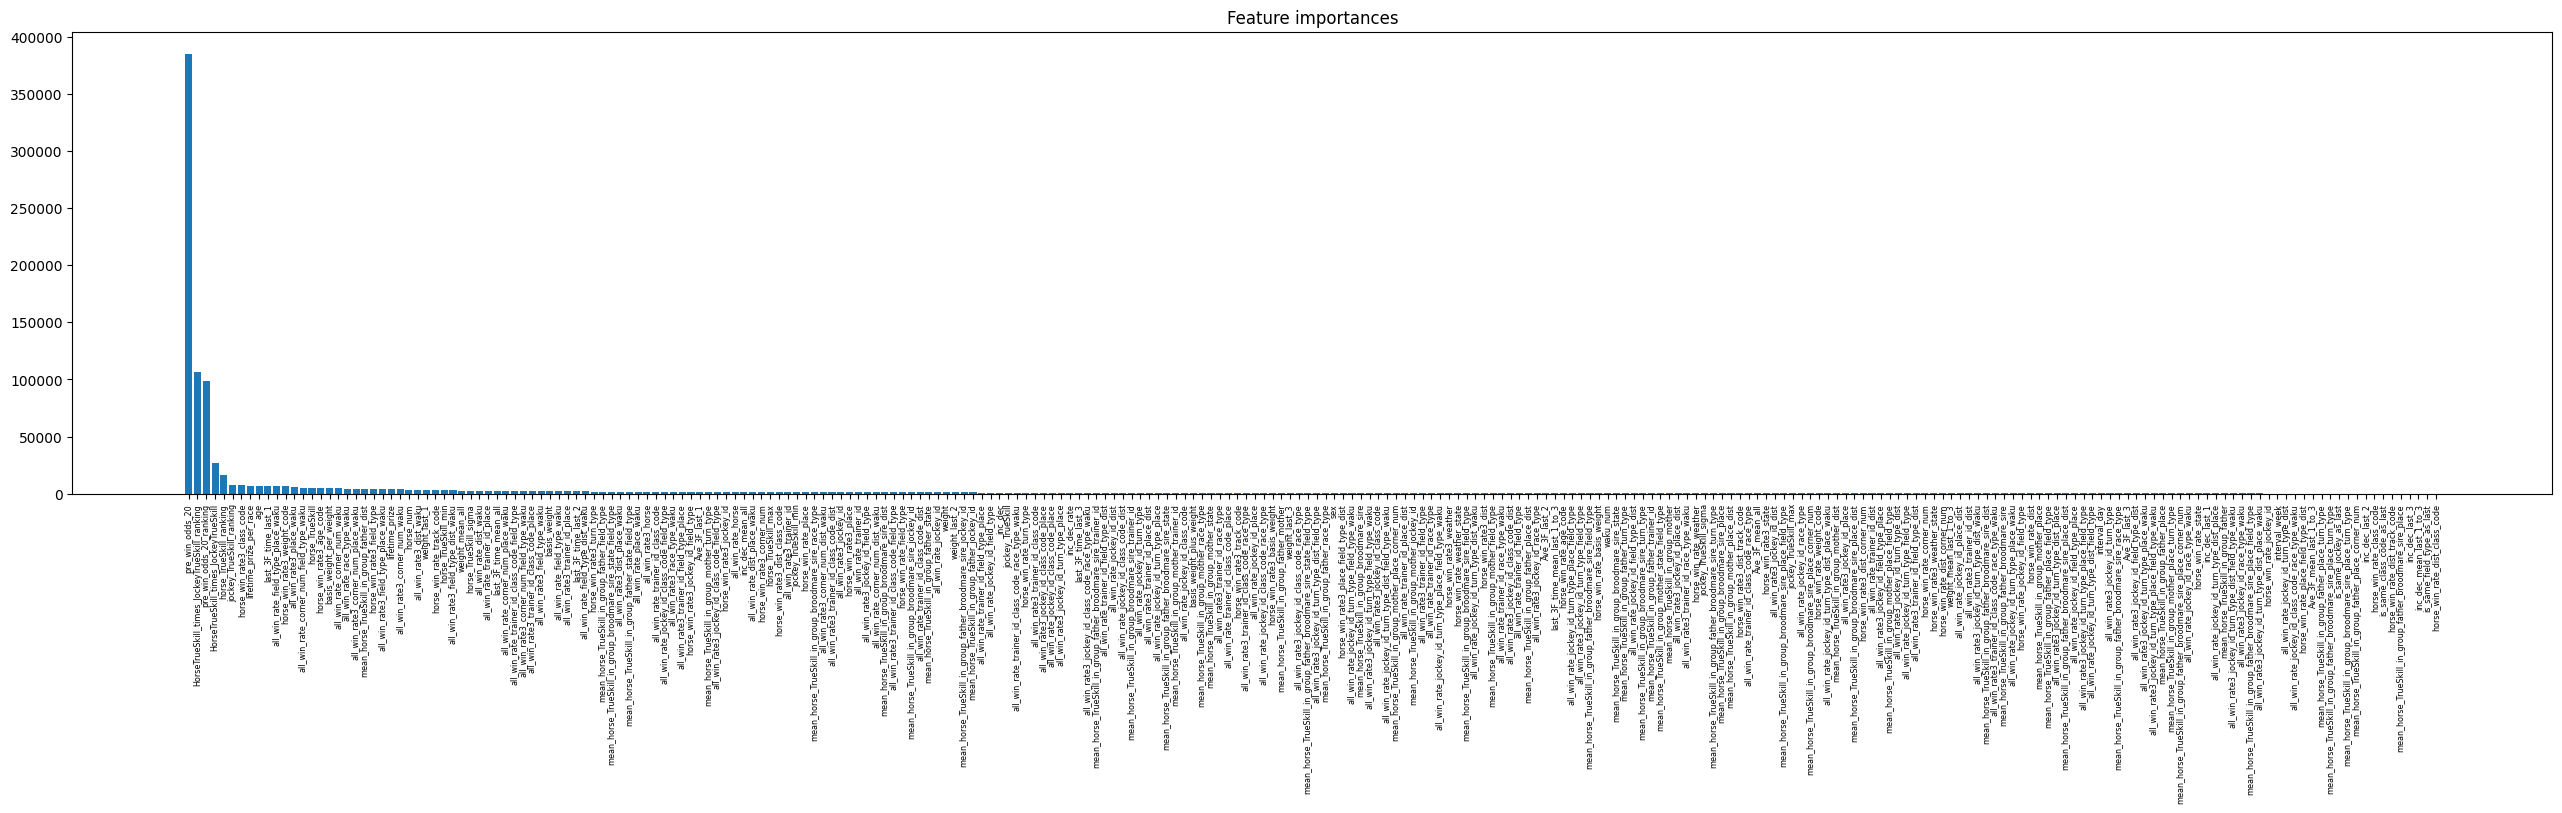

In [9]:
memo = "add grouping TrueSkill(sigma, max, min), reduce features. n_rials=30."
model, df_pred = model_tuner.simple_lightGBM(df4, feature_col2, memo=memo, n_trials=30, save_result=False, visualization=True)

In [10]:
tmp =  df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False)
tmp.head(10)

,id_for_fold,horse,pred
207687,2024062302010605,ヤンキーバローズ,0.697690
211595,2024072704020101,エンブロイダリー,0.652390
233205,2025012506010806,クレーキング,0.617919
219812,2024100605040202,エデルクローネ,0.584443
217523,2024091507030402,オトメナシャチョウ,0.580513
210666,2024072001010101,ポッドベイダー,0.570930
221866,2024102008050609,サブマリーナ,0.567180
213513,2024081107020205,カムニャック,0.563242
242818,2025040506030309,ピックデムッシュ,0.554413
206862,2024061605030609,ヘデントール,0.552668


In [11]:
df_pred[["id_for_fold", "horse", "pred"]].sort_values("pred", ascending=False).tail()

,id_for_fold,horse,pred
206215,2024061508040504,メイショウアユカゼ,0.001572
205778,2024060905030406,ラテラルアーク,0.001530
232425,2025011806010605,テルケンレングレー,0.001497
187027,2024012006010606,ホークビッツ,0.001494
192681,2024030206020305,ソーリャ,0.001410


In [12]:
df_pred[["race_id", "id_for_fold", "horse", "pred", "win_odds", "target"]].to_csv("df_pred.csv", index=False)